In [ ]:
!pip install netCDF4
!pip install cartopy
!pip uninstall shapely
!pip install shapely --no-binary shapely

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/GEO_AQ_GEMS

Mounted at /content/drive
/content/drive/MyDrive/GEO_AQ_GEMS



Would you like to process
GK2_GEMS_L2_20220225_0545_AERAOD_FW_DPRO_ORI.nc

(Y/N)y
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): nwavel(3), nwavel6(6), nwavel7(4), spatial(2048), image(695)
    variables(dimensions): 
    groups: Data Fields, Geolocation Fields, METADATA
unitless
The average of this data is:  2.13e-01 
The standard deviation is:  2.11e-01 
The median is:  1.56e-01
The range of latitude in this file is:  -6.1200314  to  51.28275 degrees 
The range of longitude in this file is:  49.44298  to  133.3013  degrees

Would you like to create a map of this data? Please enter Y or N 
y


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


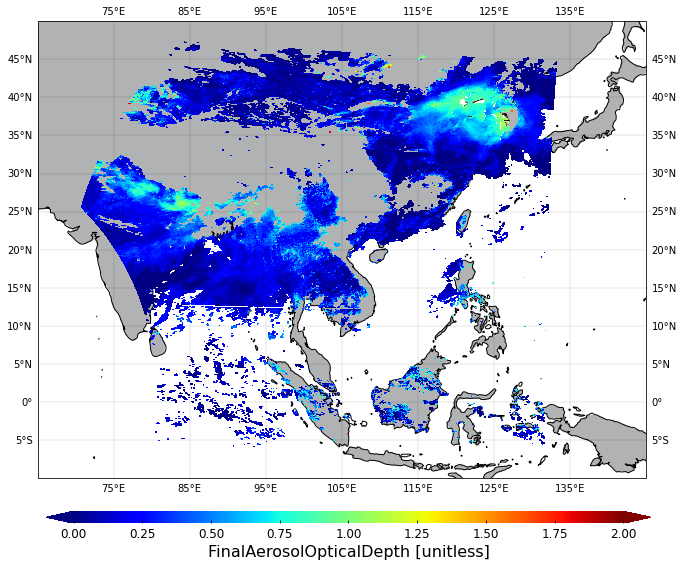


Would you like to process
GK2_GEMS_L2_20220225_0545_NO2_FW_DPRO_ORI.nc

(Y/N)y
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): nLayer(47), image(695), spatial(2048), nwavel(75)
    variables(dimensions): 
    groups: Data Fields, Geolocation Fields, METADATA
molecules cm-2
The average of this data is:  3.45e+15 
The standard deviation is:  4.10e+15 
The median is:  2.34e+15
The range of latitude in this file is:  -6.1200314  to  51.28275 degrees 
The range of longitude in this file is:  49.44298  to  133.3013  degrees

Would you like to create a map of this data? Please enter Y or N 
y


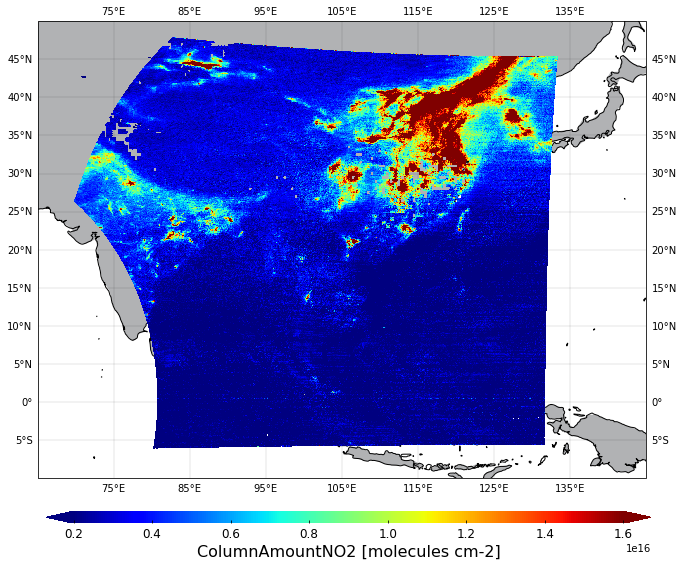

In [3]:
#!/usr/bin/python
'''
Module: read_and_map_gems_no2_ai.py
==========================================================================================
Disclaimer: The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.

Author: Justin Roberts-Pierel, 2015 
Organization: NASA ARSET
Purpose: To extract No2 or SO2 data from an OMI HDF5 file and create a map of the resulting data

See the README associated with this module for more information.
Modified by Vikalp Mishra & Pawan Gupta, May 10 2019 to read TROPOMI data
Modified by Sujung Go, September 16 2022 to read GEMS data
==========================================================================================
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sys
from netCDF4 import Dataset

#This finds the user's current path so that all hdf4 files can be found
try:
    fileList=open('fileList.txt','r')

except:
    print('Did not find a text file containing file names (perhaps name does not match)')
    sys.exit()

#loops through all files listed in the text file
for FILE_NAME in fileList:
    FILE_NAME=FILE_NAME.strip()
    user_input=input('\nWould you like to process\n' + FILE_NAME + '\n\n(Y/N)')
    if(user_input == 'N' or user_input == 'n'):
        print('Skipping...')
        continue
    else:
        file = Dataset(FILE_NAME, 'r')
        print(file)
# read the data
        ds=file
        grp='Geolocation Fields'     
        grp2='Data Fields'
        lat= ds.groups[grp].variables['Latitude'][:][:]
        lon= ds.groups[grp].variables['Longitude'][:][:]
        if 'NO2' in FILE_NAME:
            sds_name='ColumnAmountNO2'
            map_label='molecules/cm2'
        if 'AERAOD' in FILE_NAME:
            sds_name='FinalAerosolOpticalDepth'
            map_label='Aerosol Optical Depth 443nm'
        data= ds.groups[grp2].variables[sds_name]      
        
        # get necessary attributes 
        fv=data._FillValue
        
        # get lat and lon information 
        min_lat=np.min(lat)
        max_lat=np.max(lat)
        min_lon=np.min(lon)
        max_lon=np.max(lon)
        
        # set map labels
        map_label = data.units
        map_title = sds_name 
        print(data.units)
    
        # get the data as an array and mask fill/missing values
        dataArray=np.array(data[:][:])
        if 'AERAOD' in FILE_NAME:
            dataArray=np.array(data[1][:][:]) # choose 443nm 
        dataArray[dataArray==fv]=np.nan
        data=dataArray

        lon = np.where(lon==fv, np.nan, lon)
        lat = np.where(lat==fv, np.nan, lat)     
        
        # get statistics about data
        average=np.nanmean(dataArray)
        stdev=np.nanstd(dataArray)
        median=np.nanmedian(dataArray)
        
        # print statistics 
        print('The average of this data is: ','{:.2e}'.format(average),'\nThe standard deviation is: ','{:.2e}'.format(stdev),'\nThe median is: ','{:.2e}'.format(median))
        print('The range of latitude in this file is: ',min_lat,' to ',max_lat, 'degrees \nThe range of longitude in this file is: ',min_lon, ' to ',max_lon,' degrees')
        is_map=input('\nWould you like to create a map of this data? Please enter Y or N \n')
        
        # if user would like a map, view it
        if is_map == 'Y' or is_map == 'y':
            lon_range = [65., 145.]
            lat_range = [-10., 50.]
            vmin1=0.2e16
            vmax1=1.6e16
            if 'AERAOD' in FILE_NAME:
                vmin1=0.0
                vmax1=2.0

            fig = plt.figure(figsize = (8*1.5, 5.6*1.5), constrained_layout=False)     
            gs0 = fig.add_gridspec(1, 1, width_ratios=[1], height_ratios = [0.7], wspace=0, hspace=0)     
            ax = fig.add_subplot(gs0[0], projection = ccrs.PlateCarree())

            ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.OCEAN, facecolor='#ffffff')
            ax.add_feature(cfeature.LAND, facecolor='#B1B2B4', edgecolor='none', linewidth=0.1)
            ax.coastlines(resolution='50m')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            gl=ax.gridlines(xlocs=np.arange(lon_range[0], lon_range[1], 10), ylocs=np.arange(lat_range[0], lat_range[1], 5), draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.1, color='black')
            
            cm = plt.cm.get_cmap('jet')
            cm.set_bad(color='black', alpha=0.0)

            pcm0 = ax.pcolormesh(lon, lat, data, cmap=cm, vmin= vmin1, vmax= vmax1, zorder=4, alpha=1.0) 

            cbar_ax = fig.add_axes([0.17, 0.05, 0.70, 0.02])
            cb0 = plt.colorbar(pcm0, cax=cbar_ax, orientation = 'horizontal', extend='both')
            cb0.outline.set_visible(False)
            
            cb0.ax.tick_params(labelsize=12, bottom=True, direction='in')
            cb0.set_label(map_title+' ['+map_label+']', fontsize = 16)
            # Show the plot window.
            plt.subplots_adjust()
            plt.show()
           
            # Saves as a png
            pngfile = '{0}.png'.format(FILE_NAME[:-3])
            fig.savefig(pngfile, dpi = 300, bbox_inches='tight')
            plt.close()

        # Close the hdf5 file 
        file.close() 
